# [IDPP CLEF Challlenge](http://brainteaser.dei.unipd.it/challenges/idpp2023/)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor
import lightgbm

# machine learning
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import r_regression
from sklearn import preprocessing

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

In [3]:
DATASET_DIR = "../data/datasetA_train"
ID_FEAT = "patient_id"

pd.set_option('display.max_rows', None)

# Load and Merge data

In [4]:
def filenames_in_folder(dir_path):
    file_names = []
    for _, __, f_names in os.walk(dir_path):
        for file_name in f_names:
            file_names.append(file_name)
        break
    return file_names


def read_dfs(dir_path):
    file_names = filenames_in_folder(dir_path)
    dfs = {file_name.removesuffix(".csv"): pd.read_csv(os.path.join(dir_path, file_name)) for file_name in file_names if file_name.endswith("csv")}
    return dfs

dfs = read_dfs(DATASET_DIR)


In [5]:
def dfs_unique_patients(dfs):
    out = {}
    for name, df in dfs.items():
        out[name] = len(df[ID_FEAT].unique())
    return pd.DataFrame.from_dict(out, orient="index", columns=["Unique patients"])

In [6]:
def merge_dfs_complete(dfs):

    def group_ts_column_to_list(orig_df, id_feat, other_feature):
        unique_ids = orig_df[id_feat].unique()
        grouped_ts_column_as_list = orig_df.groupby(id_feat)[other_feature].apply(lambda x: x.values).values.tolist()
        new_df = pd.DataFrame.from_dict({id_feat: unique_ids,
                                         other_feature: grouped_ts_column_as_list})
        new_df = new_df.set_index(id_feat)
        return new_df

    def group_ts_column_select_first(orig_df, id_feat, other_feature):
        unique_ids = orig_df[id_feat].unique()
        first_values = orig_df.groupby(id_feat)[other_feature].apply(lambda x: x.values[0]).values

        new_df = pd.DataFrame.from_dict({id_feat: unique_ids,
                                         other_feature: first_values})
        new_df = new_df.set_index(id_feat)
        return new_df

    def group_ts_df_by_id(orig_df, id_feat, time_series_feats, one_occurrence_feats, sort_by_this_feat):
        orig_df = orig_df.sort_values(by=[ID_FEAT, sort_by_this_feat])
        ts_dfs = [group_ts_column_to_list(orig_df, id_feat, ts_feat) for ts_feat in time_series_feats]
        oo_dfs = [group_ts_column_select_first(orig_df, id_feat, oo_feat) for oo_feat in one_occurrence_feats]

        out_df = pd.concat([*oo_dfs, *ts_dfs], axis=1)
        out_df.reset_index(names=id_feat, inplace=True)
        return out_df

    merged_df = pd.merge(dfs["datasetA_train-static-vars"], dfs["datasetA_train-outcomes"],
                         on="patient_id", how="outer")

    relapses_df = dfs["datasetA_train-relapses"]
    ts_feats = ["delta_relapse_time0"]
    oo_feats = ["centre"]
    sort_by_this_feat = "delta_relapse_time0"
    relapses_df = group_ts_df_by_id(relapses_df, ID_FEAT, ts_feats, oo_feats, sort_by_this_feat)

    edss_df = dfs["datasetA_train-edss"]
    ts_feats = ["edss_as_evaluated_by_clinician", "delta_edss_time0"]
    sort_by_this_feat = "delta_edss_time0"
    edss_df = group_ts_df_by_id(edss_df, ID_FEAT, ts_feats, oo_feats, sort_by_this_feat)

    ms_type_df = dfs["datasetA_train-ms-type"]
    ts_feats = ["multiple_sclerosis_type", "delta_observation_time0"]
    sort_by_this_feat = "delta_observation_time0"
    ms_type_df = group_ts_df_by_id(ms_type_df, ID_FEAT, ts_feats, oo_feats, sort_by_this_feat)

    evoked_p_df = dfs["datasetA_train-evoked-potentials"]
    ts_feats = ["altered_potential", "potential_value", "location", "delta_evoked_potential_time0"]
    oo_feats = ["centre"]
    sort_by_this_feat = "delta_evoked_potential_time0"
    evoked_p_df = group_ts_df_by_id(evoked_p_df, ID_FEAT, ts_feats, oo_feats, sort_by_this_feat)

    mri_df = dfs["datasetA_train-mri"]
    ts_feats = ["mri_area_label", "lesions_T1", "lesions_T1_gadolinium", "number_of_lesions_T1_gadolinium",
                "new_or_enlarged_lesions_T2", "number_of_new_or_enlarged_lesions_T2", "lesions_T2", "number_of_total_lesions_T2", "delta_mri_time0"]
    sort_by_this_feat = "delta_mri_time0"
    mri_df = group_ts_df_by_id(mri_df, ID_FEAT, ts_feats, oo_feats, sort_by_this_feat)

    grouped_dfs = [edss_df, relapses_df, ms_type_df, evoked_p_df, mri_df]
    for df in grouped_dfs:
        merged_df = pd.merge(merged_df, df, on=[ID_FEAT, "centre"], how="outer")

    return merged_df

dfs = read_dfs(DATASET_DIR)
merged_df = merge_dfs_complete(dfs)

In [7]:
dfs["merged_df"] = merged_df
unique_patients = dfs_unique_patients(dfs)
unique_patients

,Unique patients
datasetA_train-edss,439
datasetA_train-evoked-potentials,153
datasetA_train-mri,279
datasetA_train-ms-type,210
datasetA_train-outcomes,440
datasetA_train-relapses,259
datasetA_train-static-vars,440
merged_df,440


# Analysing dataset

In [8]:
merged_df.columns.values

array(['patient_id', 'sex', 'residence_classification', 'ethnicity',
       'ms_in_pediatric_age', 'age_at_onset', 'diagnostic_delay',
       'spinal_cord_symptom', 'brainstem_symptom', 'eye_symptom',
       'supratentorial_symptom', 'other_symptoms', 'centre',
       'time_since_onset', 'outcome_occurred', 'outcome_time',
       'edss_as_evaluated_by_clinician', 'delta_edss_time0',
       'delta_relapse_time0', 'multiple_sclerosis_type',
       'delta_observation_time0', 'altered_potential', 'potential_value',
       'location', 'delta_evoked_potential_time0', 'mri_area_label',
       'lesions_T1', 'lesions_T1_gadolinium',
       'number_of_lesions_T1_gadolinium', 'new_or_enlarged_lesions_T2',
       'number_of_new_or_enlarged_lesions_T2', 'lesions_T2',
       'number_of_total_lesions_T2', 'delta_mri_time0'], dtype=object)

In [14]:
missing_values = ((merged_df.isnull().sum() * 100 / len(merged_df)).sort_values(ascending=False))
print("Missing value rate:\n", missing_values.to_string())

Missing value rate:
 altered_potential                       65.227273
potential_value                         65.227273
location                                65.227273
delta_evoked_potential_time0            65.227273
delta_observation_time0                 52.272727
multiple_sclerosis_type                 52.272727
delta_relapse_time0                     41.136364
lesions_T1_gadolinium                   36.590909
mri_area_label                          36.590909
lesions_T1                              36.590909
delta_mri_time0                         36.590909
new_or_enlarged_lesions_T2              36.590909
number_of_new_or_enlarged_lesions_T2    36.590909
lesions_T2                              36.590909
number_of_total_lesions_T2              36.590909
number_of_lesions_T1_gadolinium         36.590909
ethnicity                                3.636364
diagnostic_delay                         2.727273
residence_classification                 2.727273
delta_edss_time0             

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


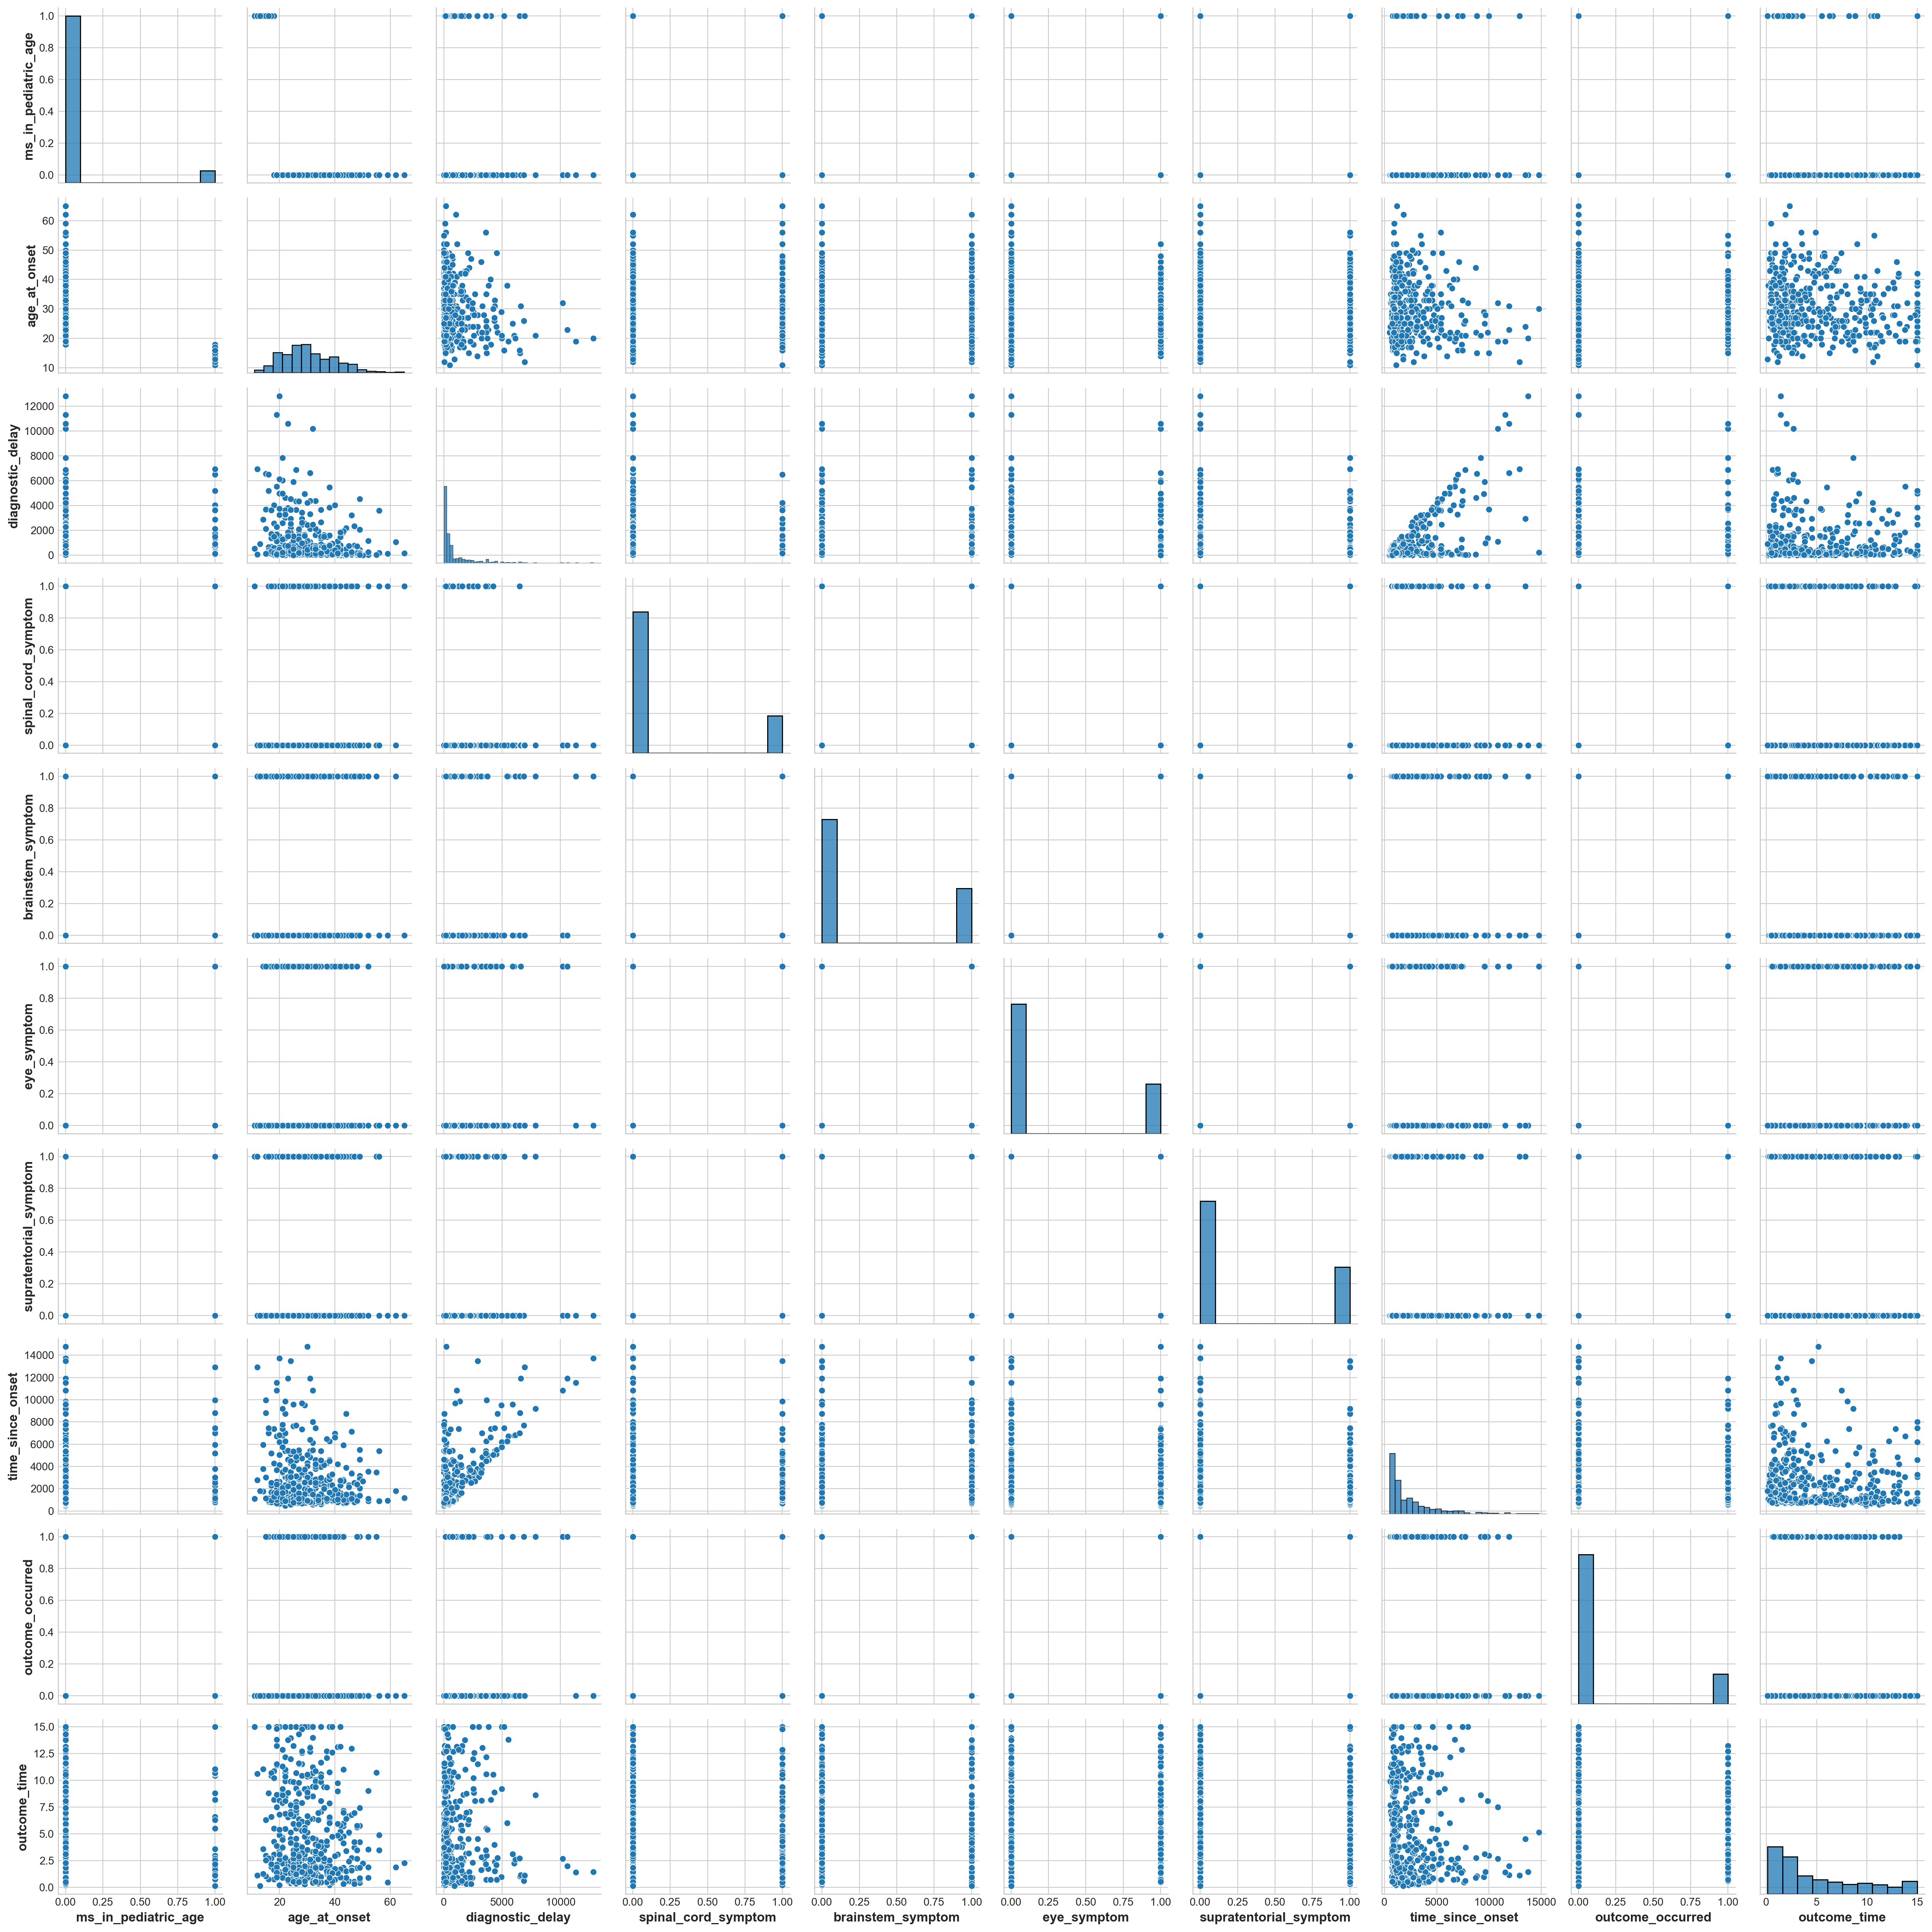

In [9]:
static_values = ['sex', 'residence_classification', 'ethnicity',
       'ms_in_pediatric_age', 'age_at_onset', 'diagnostic_delay',
       'spinal_cord_symptom', 'brainstem_symptom', 'eye_symptom',
       'supratentorial_symptom', 'other_symptoms', 'centre',
       'time_since_onset', 'outcome_occurred', 'outcome_time']
sns.pairplot(merged_df[static_values])


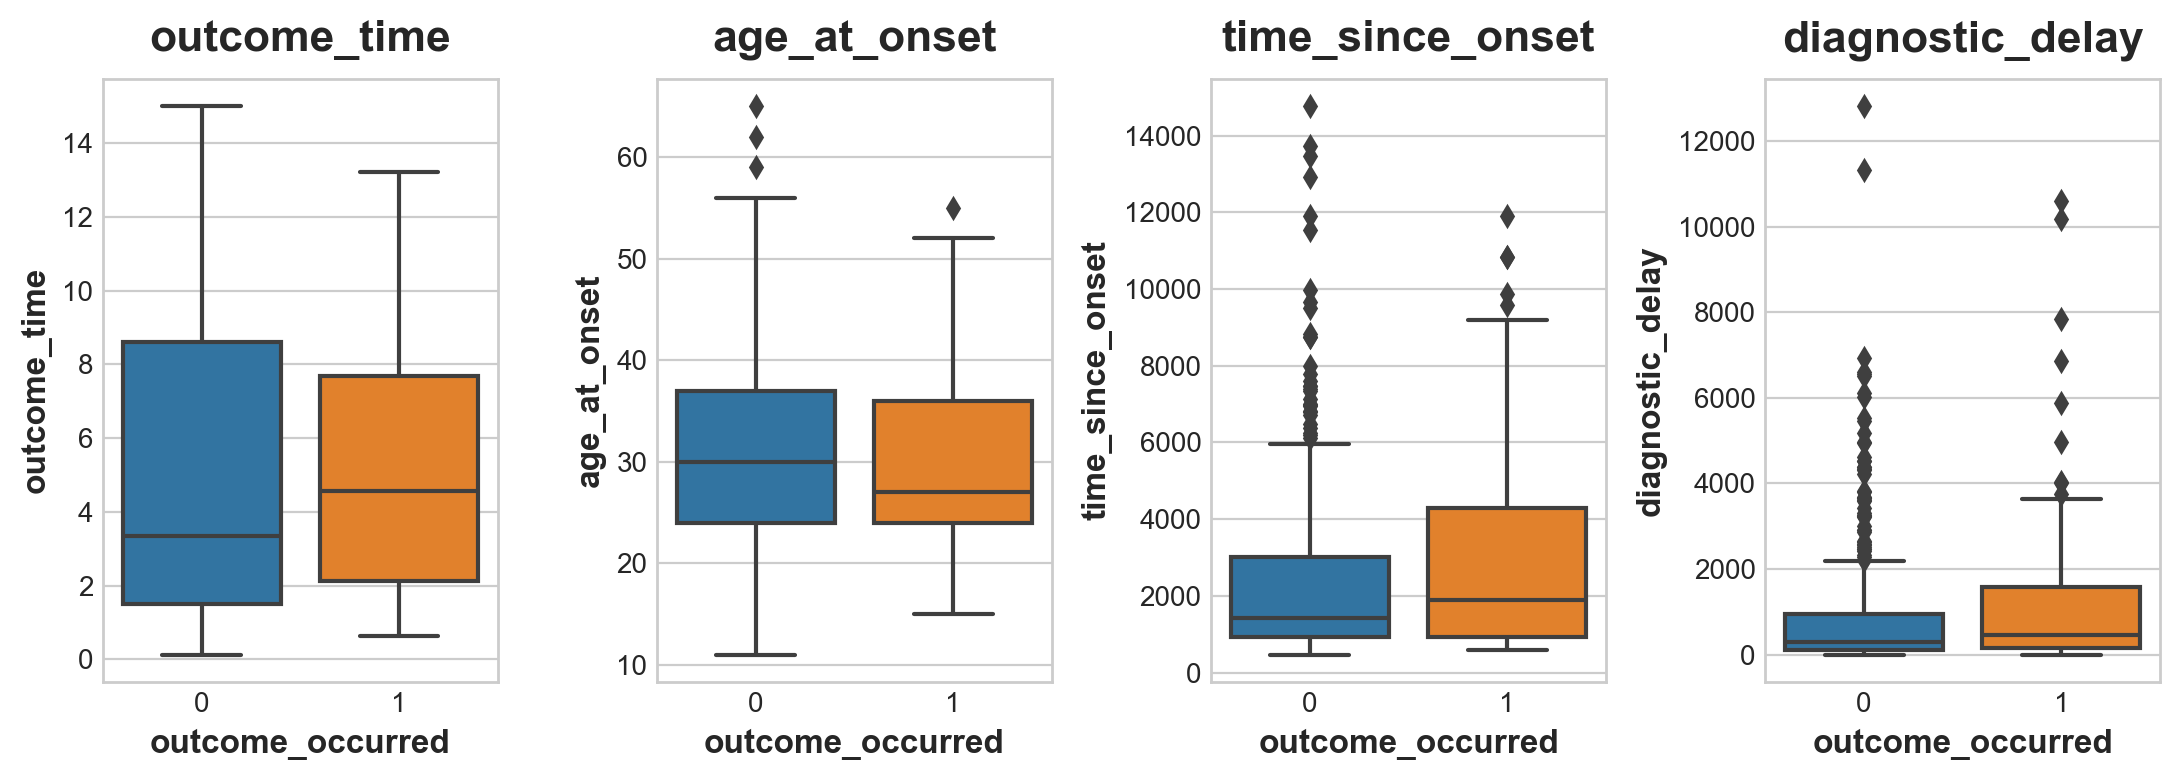

In [10]:
fig, axes = plt.subplots(1, 4)
for ax, feat in zip(axes.flat, ["outcome_time","age_at_onset", "time_since_onset","diagnostic_delay"]):
    sns.boxplot(merged_df, x="outcome_occurred", y=feat, ax=ax)
    ax.set(title=f"{feat}")

<Axes: xlabel='delta_evoked_potential_time0_len', ylabel='count'>

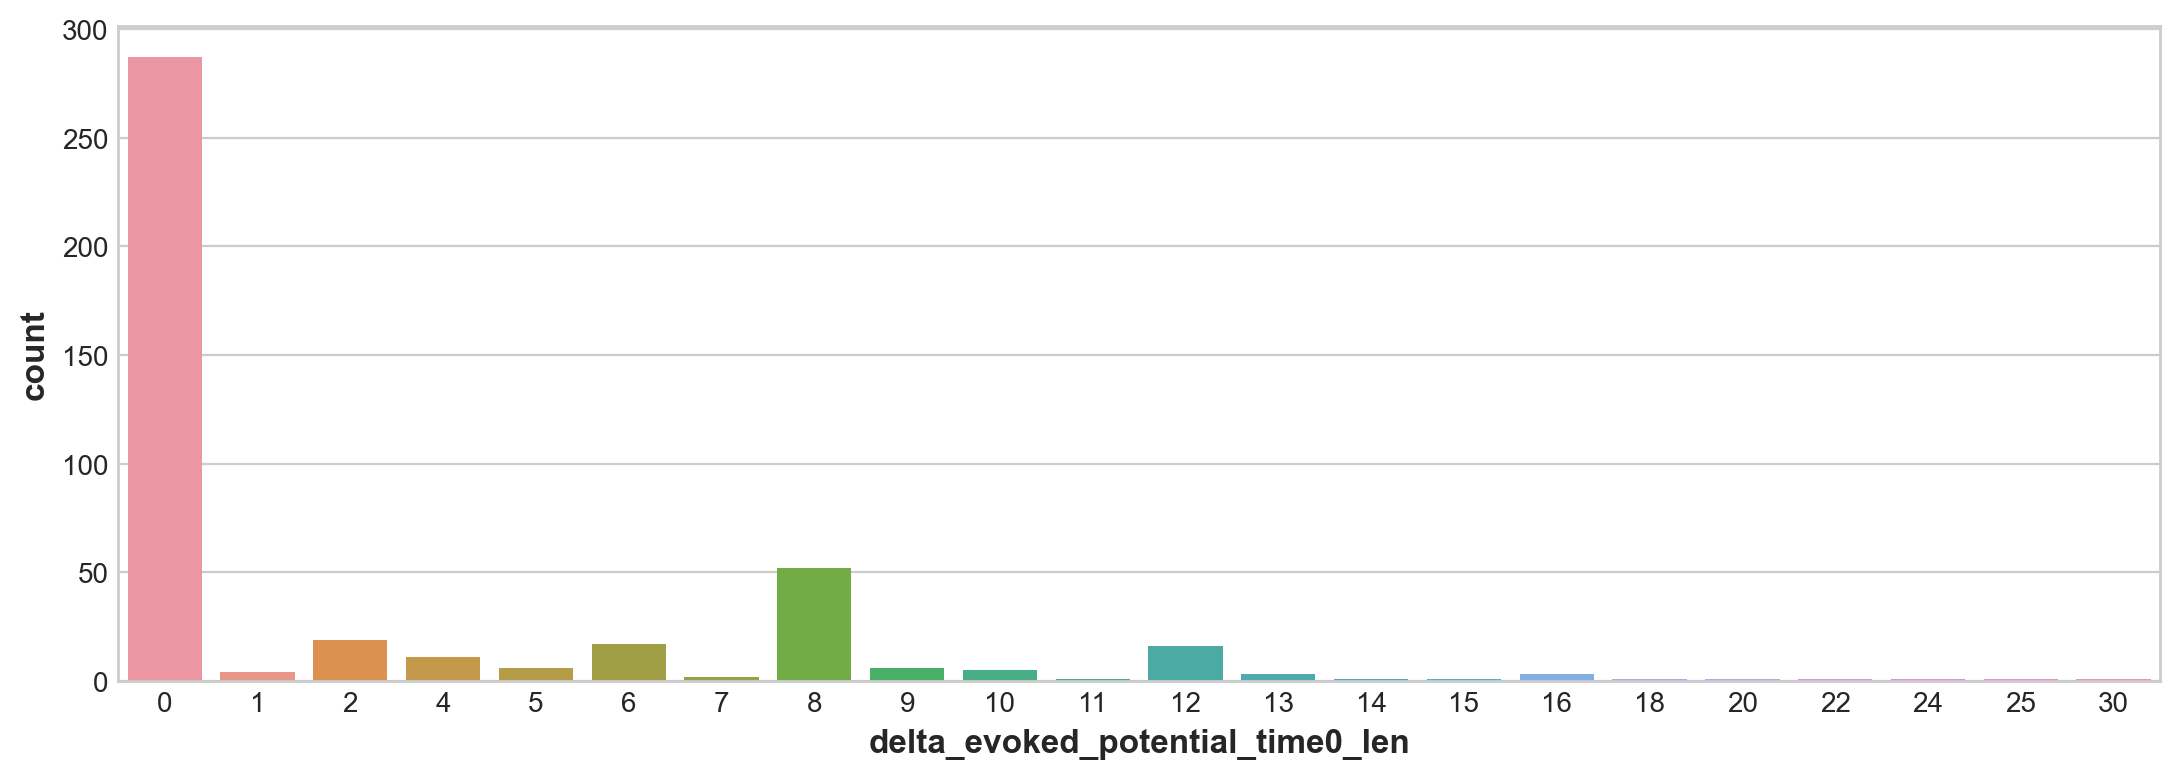

In [35]:
merged_df = merged_df.replace({np.nan: None})
def calc_len(x):
    if x is None:
        return 0
    else:
        return len(x)

plot_df = pd.DataFrame(merged_df[[ID_FEAT, "outcome_occurred", "delta_evoked_potential_time0"]])
plot_df["delta_evoked_potential_time0_na"] = plot_df["delta_evoked_potential_time0"].isna()
plot_df["delta_evoked_potential_time0_len"] = plot_df["delta_evoked_potential_time0"].apply(calc_len)

sns.countplot(x='delta_evoked_potential_time0_len', data=plot_df)

In [ ]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

